In [1]:
import numpy as np
# import igraph
from scipy import sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from bluepysnap import Circuit
# import matplotlib.patches as mpatches
from scipy.sparse import csc_matrix
import tqdm
import os

In [2]:
from graph_analysis.randomize import DistanceDependentConfigurationalModel
from graph_analysis.rich_cub import RichClubAnalysis
# from graph_analysis.randomize import ErdosRenyiModel

In [3]:
dpi=300
file_format = 'png'
fig_save_dir = f'{os.getcwd()}/output/'

In [4]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1

In [5]:
target = 'slice10'

CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)

target_synaptome = synaptome[target_indices,:][:,target_indices]
# mtypes_by_gid = c.nodes['hippocampus_neurons'].get().mtype.values

xyz = nodes.get(target)[['x','y','z']]

In [35]:
target_connectome = target_synaptome.copy()
target_connectome[target_connectome>1]=1

In [55]:
indegrees = target_connectome.sum(axis=0)

In [36]:
model = DistanceDependentConfigurationalModel(target_connectome,xyz)
dd_adj = model.generate()

12615it [00:05, 2129.23it/s]


In [13]:
import dask
import dask.bag as db
from dask.distributed import Client
import numpy as np

class RichClubAnalysis:
    """
    Class for performing rich club analysis on a square sparse CSC matrix.
    """
    
    def __init__(self, adjacency_matrix):
        """
        Initialize the RichClubAnalysis object.
        
        Parameters:
            adjacency_matrix (scipy.sparse.csc_matrix): Square sparse CSC matrix representing the graph adjacency.
        """
        self.adjacency_matrix = adjacency_matrix
        self.is_MultiGraph = np.any(self.adjacency_matrix.A > 1)
        self.is_Directed = not np.array_equal(adjacency_matrix, adjacency_matrix.T)

    def undirected_rich_club_coefficient(self, k):
        """
        Calculate the rich club coefficient for a given degree threshold.
        
        Parameters:
            k (int): Degree threshold.
            
        Returns:
            float: Rich club coefficient.
        """
        if self.is_Directed:
            raise ValueError("Error: The graph is directed!") 

        degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
        k_degrees = degrees[degrees >= k]
        kc = self.adjacency_matrix[degrees >= k, :][:, degrees >= k]
        kc_indices = kc.nonzero()
        kc_count = len(kc_indices[0])
        kc_possible = len(k_degrees) * (len(k_degrees) - 1)
        if kc_possible == 0:
            return np.nan
        return (2 * kc_count) / kc_possible
    
    def directed_rich_club_coefficient(self, k):
        """
        Calculate the rich club coefficient for a given degree threshold.
        
        Parameters:
            k (int): Degree threshold.
            
        Returns:
            float: Rich club coefficient.
        """
        if not self.is_Directed:
            raise ValueError("Error: The graph is undirected! Use undirected_rich_club_coefficient") 
            
        degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten() + np.array(self.adjacency_matrix.sum(axis=1)).flatten() # out + indegrees per node
        k_degrees = degrees[degrees >= k]
        kc = self.adjacency_matrix[degrees >= k, :][:, degrees >= k]
        kc_indices = kc.nonzero()
        kc_count = len(kc_indices[0])
        kc_possible = len(k_degrees) * (len(k_degrees) - 1)
        if kc_possible == 0:
            return np.nan
        return (kc_count) / kc_possible
    
    def plot_rich_club(self):
        """
        Plot the rich club coefficient for different degree thresholds.
        """
        degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
        k_values = np.unique(degrees)
        rc_coefficients = [self.rich_club_coefficient(k) for k in k_values]
        
        plt.plot(k_values, rc_coefficients, 'o-')
        plt.xlabel('Degree Threshold (k)')
        plt.ylabel('Rich Club Coefficient')
        plt.title('Rich Club Analysis')
        plt.show()


    def calculate_rc_coefficient(self,k):
        rc_coefficient = self.directed_rich_club_coefficient(k)
        return k, rc_coefficient

    def calculate_rich_club_coefficients(self,degree):
        '''
        degree: either in or outdegree, given from outside class
        '''
        k_values = np.arange(1, np.max(degree))
        k_dict = {}

        # Create a Dask bag from the k_values
        k_bag = db.from_sequence(k_values)

        # Parallelize the calculation of rc_coefficient for each k
        results = k_bag.map(self.calculate_rc_coefficient).compute()

        # Collect the results into k_dict
        for k, rc_coefficient in results:
            k_dict[k] = rc_coefficient

        return k_dict

In [38]:
rca = RichClubAnalysis(target_connectome)

In [39]:
import dask
import dask.bag as db
from dask.distributed import Client

In [43]:
dd_adj = sparse.load_npz('../output/random_models/dd_configurational_slice10.npz')

In [47]:
indegrees_dd = dd_adj.sum(axis=0)

In [10]:
# num_syns_per_conn = target_synaptome.sum() / target_synaptome.count_nonzero()
# num_syns_per_conn = np.round(num_syns_per_conn).astype(int)

In [11]:
# dd_synaptme = dd_adj.copy().astype(int)
# dd_synaptme *= num_syns_per_conn

In [44]:
rca_dd = RichClubAnalysis(dd_adj.astype(int))

In [ ]:
# model_outdegree = model.to_connectome(model.synaptome).sum(axis=1).flatten()
# dd_outdegree = dd_adj.sum(axis=1).flatten()
# np.testing.assert_array_equal(model_outdegree,dd_outdegree)

# # save adjacency matrix
# sparse.save_npz(f'{save_dir}/dd_configurational_{target}.npz',dd_adj)

In [15]:
import networkx as nx

In [45]:
num_nodes = target_synaptome.shape[1]

In [46]:
conn_prob = target_synaptome.count_nonzero() / (target_synaptome.shape[0] * (target_synaptome.shape[0]-1))

In [32]:
target_er = nx.erdos_renyi_graph(num_nodes,conn_prob,seed=10,directed=True)
adj_er = nx.adjacency_matrix(target_er)
rca_er = RichClubAnalysis(adj_er)
indegree_er = adj_er.sum(axis=0)

/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/scipy/sparse/_base.py:752: VisibleDeprecationWarning: Please use `.todense()` instead
  warn(np.VisibleDeprecationWarning(
<__array_function__ internals>:200: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


In [51]:
indegree_er.max()

282

In [53]:
indegrees_dd.max()

378

In [96]:
np.squeeze(indegrees.A).astype(int).max()

1493

In [103]:
target_connectome.sum(axis=1).A.flatten()

array([390.,  22., 299., ..., 596., 347., 687.])

In [105]:
target_connectome.sum(axis=0).A.flatten().max() 

1493.0

In [107]:
target_connectome.sum(axis=1).A.flatten().max() 

3732.0

In [94]:
# in or outdegree alone is not graphical so degree preserving randomization is not feasable
# but total degree is
dg = connectome.sum(axis=1).A.flatten() + connectome.sum(axis=0).A.flatten()
nx.is_graphical(dg)

True

In [114]:
M = target_synaptome.tocoo()
M.col = np.random.permutation(M.col)

In [118]:
np.testing.assert_array_almost_equal(M.sum(axis=0).A.flatten(),
                              M.sum(axis=0).A.flatten())

In [95]:
G_degree_preserving = nx.random_degree_sequence_graph(dg, seed=42)

KeyboardInterrupt: 

In [48]:
# Example usage

# Start Dask client
client = Client()

k_dict_parallel_model = rca.calculate_rich_club_coefficients(indegrees)
k_dict_parallel_dd = rca_dd.calculate_rich_club_coefficients(indegrees_dd)
k_dict_parallel_er = rca_er.calculate_rich_club_coefficients(indegree_er)

# Shutdown the Dask client
client.shutdown()


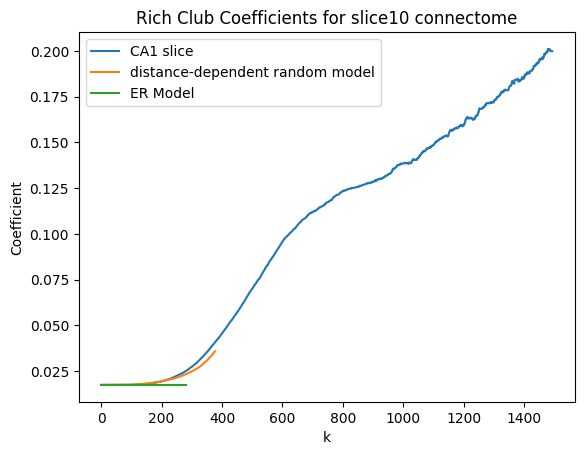

In [50]:
plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())

plt.title('Rich Club Coefficients for slice10 connectome')
plt.xlabel('k')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice','distance-dependent random model','ER Model'])
plt.savefig(f"../output/rich_club_directed_indegree.png", dpi=dpi, bbox_inches='tight')

In [ ]:
plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())

plt.title('Rich Club Coefficients for slice10 connectome')
plt.xlabel('k')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice','distance-dependent random model','ER Model'])
plt.savefig(f"../output/rich_club_directed_indegree.png", dpi=dpi, bbox_inches='tight')

In [ ]:
# rc for indegree for synaptome 
rca = RichClubAnalysis(target_connectome)






# Example usage

# Start Dask client
client = Client()

k_dict_parallel_model = rca.calculate_rich_club_coefficients(indegrees)
k_dict_parallel_dd = rca_dd.calculate_rich_club_coefficients(indegrees_dd)
k_dict_parallel_er = rca_er.calculate_rich_club_coefficients(indegree_er)

# Shutdown the Dask client
client.shutdown()



plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())
plt.plot(k_dict_parallel_er.keys(),k_dict_parallel_er.values())

plt.title('Rich Club Coefficients for slice10 connectome')
plt.xlabel('k')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice','distance-dependent random model','ER Model'])
plt.savefig(f"../output/rich_club_directed_indegree.png", dpi=dpi, bbox_inches='tight')


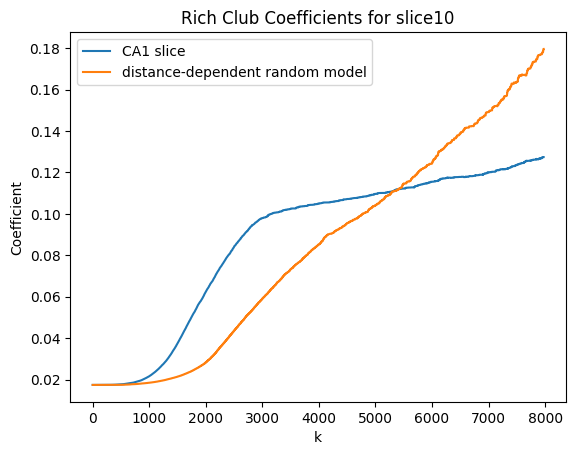

In [41]:
plt.plot(k_dict_parallel_model.keys(),k_dict_parallel_model.values())
plt.plot(k_dict_parallel_dd.keys(),k_dict_parallel_dd.values())

plt.title('Rich Club Coefficients for slice10')
plt.xlabel('k')
plt.ylabel('Coefficient')
plt.legend(['CA1 slice','distance-dependent random model'])
plt.savefig(f"../output/rich_club_directed_indegree.png", dpi=dpi, bbox_inches='tight')

In [ ]:
# rc for total-degree for connectome 


In [ ]:
# rc for total-degree for synaptome 
